# How to use acrg_obs

acrg_obs is a set of functions designed to make processing and manipulating observation data more straight forward.

In this tutorial, we'll go through: 1) how to process data, 2) how to read data.

NOTE: On BP1, raw (unprocessed) data files are stored at:

```shared/obs_raw/<PROJECT>```

Where project is a suitable descriptor that tells the reader where the data came from (e.g. AGAGE, UEA, etc.)

and processed netcdf files are at 

```shared/obs/<SITE_CODE>/```

In [1]:
import os
import acrg_obs as obs
import matplotlib.pyplot as plt

## 1. Processing observations

### 1.1 GCWerks data

A common dataset that needs processing is the output from GCWerks for AGAGE and DECC network sites. This output has its own set of functions.

Firstly, sync relevant files from DAGAGE2 to BP1 using the following shell script (this will take a few minutes):

```acrg_obs/process_gcwerks_dagage2.sh```

This function stores raw DAGAGE2 output in ```shared/obs_raw/AGAGE_GCWerks```

You can now process individual datasets using the functions in acrg_obs/process_gcwerks:

In [2]:
# e.g. let's process some GC multidetector (MD) data from MHD
obs.process_gcwerks.gc("MHD", "GCMD", "AGAGE")

Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.00.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.01.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.02.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.03.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.04.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.05.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.06.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.07.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.08.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.09.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.10.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.11.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.12.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks/data/macehead.13.C
Reading /work/chxmr/shared/obs_raw/AGAGE_GCWerks

The above should tell you that it's read a bunch of .C files and written some netcdf (.nc) files.

**Important**: it's now critical to do two steps:
1. clean up the MHD directory, so that only the most recent data version remains there and older versions are archived
2. update the obs database

In [3]:
obs.utils.cleanup("MHD")

Checking for files to archive in /work/chxmr/shared/obs/MHD ...
... everything up-to-date for AGAGE-GCMSMedusa
... everything up-to-date for ICOS-picarroG2401
... archiving AGAGE-GCECD files, version 20201116
... everything up-to-date for ICOS-picarro
... archiving AGAGE-GCFID files, version 20201116
... everything up-to-date for AGAGE-GCMS
... archiving AGAGE-GCRGA files, version 20201116


In [4]:
obs.utils.obs_database()

Reading obs files in /work/chxmr/shared/obs
Writing database /work/chxmr/shared/obs/obs.db


this should have created an updated obs database at ```shared/obs/obs.db```

#### 1.1.1 Processing all GCWerks data

You can process and cleanup all the GCWerks data by submitting the following array job (assuming you're in the arcg_obs directory here):

```qsub -V -J 1-40 -k oe -j oe -Wsandbox=PRIVATE process_gcwerks_array.sh```

Make sure that you update the database after you've done this (you can skip the cleanup step) ```obs.utils.obs_database()```

## 1.2 Processing other data

Firstly, make sure that you store a copy of the "raw" data files in shared/obs_raw, under an appropriate folder name. This is to ensure tracability. If your datasets are really big (e.g. Satellite data), we don't necessarily need to do this, but just make sure you point to an appropriate online source.

Next, you'll need to create a processing function in acrg_obs/process_misc.py. There are four components of these processing routines:

1. Read the data into an xarray dataset (most of the current routines use Pandas to do this). Make sure you've created variables with names like "ch4" (mole fraction), "ch4_repeatability", "ch4_number_of_observations", etc.

2. Run that dataset through ```obs.utils.attributes```, which will ensure that all the variables and attributes are properly formatted.

3. Run ```obs.utils.output_filename```, which creates an appropriate filename.

4. Save the file using ```ds.to_netcdf(filename)```

Remember to include appropriate global attributes (e.g. data owner contact details. You may need to add details to acrg_site_info.json

**Remember** to update the database when you're done: ```obs.utils.obs_database()```

## 2. Reading observations

To get a single species from a single site, use read.get_single_site:

In [6]:
ds = obs.get_single_site("BSD", "N2O", average = "1D")

... reading /work/chxmr/shared/obs/BSD/DECC-GCECD_BSD_20170317_n2o-248m-20200928.nc
... slicing from 2017-03-17 00:00:00 to 2019-03-05 23:59:59.999999999
... resampling to 1D


/home/chxmr/.conda/envs/matt/lib/python3.8/site-packages/xarray/core/common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


... reading /work/chxmr/shared/obs/BSD/DECC-GCECD_BSD_20140131_n2o-108m-20200928.nc
... slicing from 1900-01-01 00:00:00 to 2017-03-16 23:59:59.999999999
... resampling to 1D


/home/chxmr/.conda/envs/matt/lib/python3.8/site-packages/xarray/core/common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


... reading /work/chxmr/shared/obs/BSD/DECC-picarro5310_BSD_20190306_n2o-248m-20200928.nc
... slicing from 2019-03-06 00:00:00 to 2099-12-31 23:59:59.999999999
... resampling to 1D


/home/chxmr/.conda/envs/matt/lib/python3.8/site-packages/xarray/core/common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


... suggest setting calibration_scale to convert


This will create a list of xarray datasets, which looks like this:

In [7]:
ds[0]

<xarray.Dataset>
Dimensions:           (time: 719)
Coordinates:
  * time              (time) datetime64[ns] 2017-03-17 2017-03-18 ... 2019-03-05
Data variables:
    mf                (time) float32 330.69724 330.84512 ... 332.58258 332.70694
    mf_repeatability  (time) float64 0.05557 0.02686 0.02538 ... 0.0308 0.02722
    status_flag       (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    integration_flag  (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    data_owner:           Simon O'Doherty
    data_owner_email:     s.odoherty@bristol.ac.uk
    comment:              Gas chromatograph measurements. Output from GCWerks.
    inlet_magl:           248m
    inlet_gcwerks:        248m
    Conditions of use:    Ensure that you contact the data owner at the outse...
    Source:               In situ measurements of air
    Conventions:          CF-1.6
    File created:         2020-09-28 12:51:05.654353+00:00
    Processed by:         chxmr@bristol.ac.uk
    species:              N2O
    station_longitude:    -1.15033
    station_latitude:     54.35858
    station_long_name:    Bilsdale, UK
    station_height_masl:  380.0
    filename:             /work/chxmr/shared/obs/BSD/DECC-GCECD_BSD_20170317_...
    inlet:                248m
    instrument:           GCECD
    scale:                SIO-16

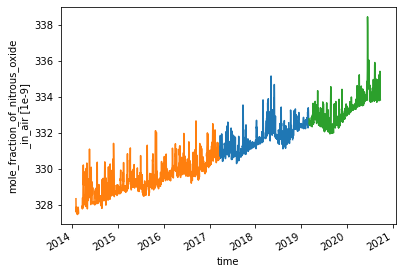

In [8]:
for d in ds:
    d.mf.plot()

Here, you'll see that the data is split into three separate datasets. Each dataset represents the data *for a particular combination of instruments and inlets*. The reason for splitting it up in this way is to ensure that there's no ambiguity when e.g. comparing model and data at the correct height.

In this case, N2O at BSD was initially measured at the 108m inlet on the GCECD. Then it switched to the 248m inlet, and then the instrument was upgraded to a Picarro 5810.

The default instruments and inlets for each site and species are contained in the ```acrg_obs/acrg_obs_defaults.csv``` file. 

To grab data from multiple sites, use get_obs:

In [9]:
n2o = obs.get_obs(["BSD", "MHD"], "N2O", average = "1D", start_date="2019-01-01", end_date = "2020-01-01", calibration_scale="WMO-X2006A")

Assuming status flag = 0 for all sites
Getting N2O data for BSD...
... reading /work/chxmr/shared/obs/BSD/DECC-GCECD_BSD_20170317_n2o-248m-20200928.nc
... slicing from 2019-01-01 00:00:00 to 2019-03-05 23:59:59.999999999
... resampling to 1D
... converting scale to WMO-X2006A
... reading /work/chxmr/shared/obs/BSD/DECC-picarro5310_BSD_20190306_n2o-248m-20200928.nc
... slicing from 2019-03-06 00:00:00 to 2019-12-31 23:59:59.999999999
... resampling to 1D


/home/chxmr/.conda/envs/matt/lib/python3.8/site-packages/xarray/core/common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/chxmr/.conda/envs/matt/lib/python3.8/site-packages/xarray/core/common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Getting N2O data for MHD...
... reading /work/chxmr/shared/obs/MHD/AGAGE-GCECD_MHD_19940217_n2o-20201119.nc
... slicing from 2019-01-01 00:00:00 to 2019-12-31 23:59:59.999999999
... resampling to 1D


/home/chxmr/.conda/envs/matt/lib/python3.8/site-packages/xarray/core/common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


... converting scale to WMO-X2006A


Now, we've returned a dictionary of lists of datasets (sorry!). The keys are the site codes and the values are lists of datasets returned by get_single_site:

In [10]:
n2o

{'BSD': [<xarray.Dataset>
  Dimensions:           (time: 64)
  Coordinates:
    * time              (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-03-05
  Data variables:
      mf                (time) float32 186.11253 186.11336 ... 186.24625 186.31589
      mf_repeatability  (time) float64 0.02433 0.0277 0.02362 ... 0.0308 0.02722
      status_flag       (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
      integration_flag  (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  Attributes:
      data_owner:           Simon O'Doherty
      data_owner_email:     s.odoherty@bristol.ac.uk
      comment:              Gas chromatograph measurements. Output from GCWerks.
      inlet_magl:           248m
      inlet_gcwerks:        248m
      Conditions of use:    Ensure that you contact the data owner at the outse...
      Source:               In situ measurements of air
      Conventions:          CF-1.6
      File created:         2020-09-28 12:51:05.654353+00:00


Note that, above, we converted calibration scales using the calibration_scale keyword. Calibration scale conversion functions can be defined in ```acrg_obs/acrg_obs_scale_convert.csv```.

In this case, we converted all the instruments to the WMO-X2006A scale. You can retrieve the calibration scale from the dataset attributes:

In [11]:
n2o["BSD"][0].attrs["scale"]

'WMO-X2006A'

Similarly, to find the inlet:

In [12]:
n2o["BSD"][0].attrs["inlet"]

'248m'